##### 01/02/2026
##### Aurélien Desvilles                                                                                                              
##### RCP 209 : Apprentissage statistique 2
##                             Attaques adverses par descente rapide de gradient sur des modèles pré-entrainés sur ImageNet

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
import json

#### Importation des modèles

In [3]:
VGG_model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="convnext_xlarge",
)
VGG_model.trainable = False

In [10]:
ResNet_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="convnext_xlarge",
)
ResNet_model.trainable = False

In [11]:
Inception_model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="convnext_xlarge",
)
Inception_model.trainable = False

In [6]:
# ImageNet labels
decode_predictions = tf.keras.applications.imagenet_utils.decode_predictions

## 1: Performances des modèles sur des images normales

In [14]:
# Prétraitement
def load_and_preprocess(path, model_type):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.cast(img, tf.float64)
    if model_type == "InceptionV3":
        img = tf.image.resize(img, (299, 299))
    else:
        img = tf.image.resize(img, (224, 224))
    
    
    
    img = tf.expand_dims(img, axis=0)

    if model_type == "InceptionV3":
        img = tf.keras.applications.inception_v3.preprocess_input(img)
    elif model_type == "ResNet50":
        img = tf.keras.applications.resnet50.preprocess_input(img)
    elif model_type == "VGG19":
        img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return img

In [ ]:

# Fonction auxiliaire pour extraire les étiquettes d'un vecteur de probabilité
def get_imagenet_label(probs):
    """
    Returns a list of (class_name, probability)
    """
    decoded = decode_predictions(probs, top=1)[0]
    return [(class_name, prob) for (_, class_name, prob) in decoded]

##### A: Pour une image

In [15]:
image_path ='./ImageNet-Mini/images/n01443537/ILSVRC2012_val_00000994.JPEG'

#Pour voir l'image:
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# Prétraitement pour chaque modèle:
image_VGG = load_and_preprocess(image_path,"VGG19")
image_ResNet = load_and_preprocess(image_path,"ResNet50")
image_Inception = load_and_preprocess(image_path,"InceptionV3")

Montrer l'image:

<function matplotlib.pyplot.show(close=None, block=None)>

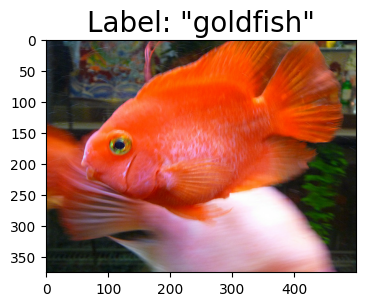

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title('Label: "goldfish"', size=20)
plt.axis("on")
plt.show

Test des 3 models sur l'image

In [16]:
# A probability vector for each model:
VGG_image_probs = VGG_model.predict(image_VGG)
ResNet_image_probs = ResNet_model.predict(image_ResNet)
Inception_image_probs = Inception_model.predict(image_Inception)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


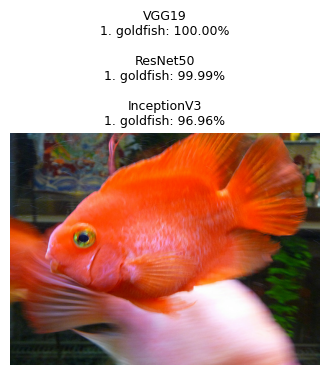

In [26]:
def format_predictions(model_name, preds):
    lines = [f"{i+1}. {name}: {prob*100:.2f}%"
             for i, (name, prob) in enumerate(preds)]
    return f"{model_name}\n" + "\n".join(lines)


vgg_top = get_imagenet_label(VGG_image_probs)
resnet_top = get_imagenet_label(ResNet_image_probs)
inception_top = get_imagenet_label(Inception_image_probs)


plt.figure(figsize=(4, 4))
plt.imshow(image)  # [-1,1] → [0,1]
plt.axis("off")

title = (
    format_predictions("VGG19", vgg_top) + "\n\n" +
    format_predictions("ResNet50", resnet_top) + "\n\n" +
    format_predictions("InceptionV3", inception_top)
)

plt.title(title, fontsize=9)
plt.show()

#### B: Performences des 3 modèles sur tout le dataset

In [ ]:
# Fichier metadata:
with open("./ImageNet-Mini/imagenet_class_index.json", "r") as f:
    imagenet_index = json.load(f)

# WordNet ID → ImageNet class index
wnid_to_imagenet = {
    v[0]: int(k) for k, v in imagenet_index.items()
}

# ImageNet index → class name
imagenet_names = {
    int(k): v[1] for k, v in imagenet_index.items()
}


In [ ]:
# a transférer
def load_and_preprocess_np(path, model_type=None):
    """
    Charge une image adversariale sauvegardée en .npy
    (déjà prétraitée pour le modèle)
    """
    img = np.load(path)              # (H,W,3) ou (1,H,W,3)
    img = tf.convert_to_tensor(img, dtype=tf.float64)

    if len(img.shape) == 3:
        img = tf.expand_dims(img, axis=0)  # (1,H,W,3)

    return img   # déjà dans l'espace d'entrée du modèle


In [ ]:
def evaluate_model(model, model_name, root_dir):
    top1, top5, total = 0, 0, 0

    # Stats globales
    top5_predicted_classes = Counter()

    # Stats par classe
    class_total = defaultdict(int)
    class_top1 = defaultdict(int)
    class_top5 = defaultdict(int)

    for wnid in tqdm(os.listdir(root_dir), desc=f"{model_name}"):
        class_dir = os.path.join(root_dir, wnid)
        if not os.path.isdir(class_dir):
            continue

        true_class = wnid_to_imagenet[wnid]
        class_name = imagenet_names[true_class]

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            x = load_and_preprocess_np(img_path, model_type=model_name)
            preds = model.predict(x, verbose=0)[0]
            top5_idx = np.argsort(preds)[-5:][::-1]

            total += 1
            class_total[class_name] += 1

            # Global accuracy
            if top5_idx[0] == true_class:
                top1 += 1
                class_top1[class_name] += 1

            if true_class in top5_idx:
                top5 += 1
                class_top5[class_name] += 1

            # Classes les plus souvent prédites
            for idx in top5_idx:
                top5_predicted_classes[imagenet_names[idx]] += 1

    # Accuracy par classe
    class_acc = []
    for cls in class_total:
        class_acc.append({
            "class": cls,
            "samples": class_total[cls],
            "top1_acc": class_top1[cls] / class_total[cls],
            "top5_acc": class_top5[cls] / class_total[cls],
        })

    # Tri
    best_top1 = sorted(class_acc, key=lambda x: x["top1_acc"], reverse=True)[:5]
    worst_top1 = sorted(class_acc, key=lambda x: x["top1_acc"])[:5]

    return {
        "global_top1": 100 * top1 / total,
        "global_top5": 100 * top5 / total,
        "most_predicted_classes": top5_predicted_classes.most_common(5),
        "best_classes_top1": best_top1,
        "worst_classes_top1": worst_top1,
    }



In [59]:
Inception_model = tf.keras.applications.InceptionV3(weights="imagenet")
VGG_model = tf.keras.applications.VGG19(weights="imagenet")
ResNet_model = tf.keras.applications.ResNet50(weights="imagenet")



In [82]:
DATASET_PATH = "./ImageNet-Mini/images"

results = {
    "InceptionV3": evaluate_model(Inception_model, "InceptionV3", DATASET_PATH),
    "VGG19": evaluate_model(VGG_model, "VGG19", DATASET_PATH),
    "ResNet50": evaluate_model(ResNet_model, "ResNet50", DATASET_PATH),
    
}


ResNet50: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s]


On affiche les performances 

In [83]:
for model_name, res in results.items():
    print(f"\n=== {model_name} ===")
    
    print(f"Top-1 Accuracy: {res['global_top1']:.2f}%")
    print(f"Top-5 Accuracy: {res['global_top5']:.2f}%")

    print("\n📈 Classes les mieux reconnues (Top-1):")
    for c in res["best_classes_top1"]:
        print(f"{c['class']} — {c['top1_acc']*100:.1f}% ({c['samples']} images)")

    print("\n📉 Classes les plus difficiles (Top-1):")
    for c in res["worst_classes_top1"]:
        print(f"{c['class']} — {c['top1_acc']*100:.1f}% ({c['samples']} images)")

    print("\n🔥 Classes les plus souvent prédites (Top-5):")
    for cls, count in res["most_predicted_classes"]:
        print(f"{cls}: {count}")



=== InceptionV3 ===
Top-1 Accuracy: 76.42%
Top-5 Accuracy: 93.32%

📈 Classes les mieux reconnues (Top-1):
tench — 100.0% (3 images)
goldfish — 100.0% (3 images)
great_white_shark — 100.0% (5 images)
stingray — 100.0% (3 images)
hen — 100.0% (3 images)

📉 Classes les plus difficiles (Top-1):
green_lizard — 0.0% (2 images)
sidewinder — 0.0% (3 images)
barn_spider — 0.0% (1 images)
cairn — 0.0% (2 images)
Appenzeller — 0.0% (3 images)

🔥 Classes les plus souvent prédites (Top-5):
screwdriver: 58
maillot: 56
can_opener: 55
crane: 52
radio: 48

=== VGG19 ===
Top-1 Accuracy: 65.51%
Top-5 Accuracy: 86.72%

📈 Classes les mieux reconnues (Top-1):
tench — 100.0% (3 images)
great_white_shark — 100.0% (5 images)
hen — 100.0% (3 images)
ostrich — 100.0% (3 images)
goldfinch — 100.0% (4 images)

📉 Classes les plus difficiles (Top-1):
green_lizard — 0.0% (2 images)
barn_spider — 0.0% (1 images)
Australian_terrier — 0.0% (3 images)
Brittany_spaniel — 0.0% (2 images)
Doberman — 0.0% (3 images)

🔥 Clas

### 1: Attaque FGSM non ciblée

#### A: Pour une image
Non allons créer un filtre spécifique à chaque modèle sur l'image de poisson rouge vue précédement.

In [27]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        preds = model(input_image)
        label = tf.one_hot(tf.argmax(preds[0]), preds.shape[-1])
        label = tf.reshape(label, (1, -1))
        loss = loss_object(label, preds)

    gradient = tape.gradient(loss, input_image)
    return tf.sign(gradient)


In [30]:
models = {
    "VGG19": {
        "model": VGG_model,
        "size": (224, 224),
        "preprocess": vgg19.preprocess_input
    },
    "ResNet50": {
        "model": ResNet_model,
        "size": (224, 224),
        "preprocess": resnet50.preprocess_input
    },
    "InceptionV3": {
        "model": Inception_model,
        "size": (299, 299),
        "preprocess": inception_v3.preprocess_input
    }
}


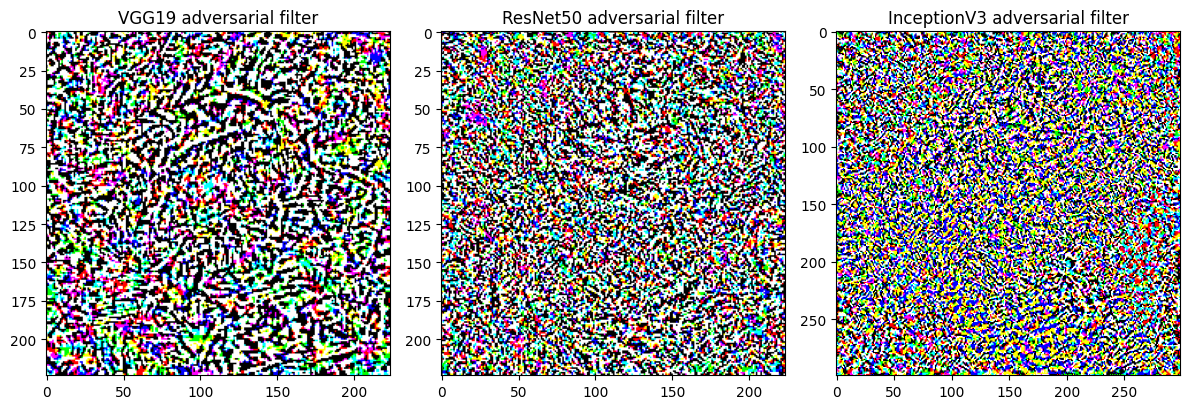

In [31]:
# Get the input label of the image.
probs = {VGG_model:["VGG19",VGG_image_probs],ResNet_model:["ResNet50",ResNet_image_probs],Inception_model:["InceptionV3",Inception_image_probs]}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
goldfish_index = 1

for ax, (model, prob) in zip(axes, probs.items()):
    label = tf.one_hot(goldfish_index, prob[1].shape[-1])
    label = tf.reshape(label, (1, prob[1].shape[-1]))

    if model == Inception_model:
        image = image_Inception          # 299×299
    elif model == ResNet_model:
        image = image_ResNet             # 224×224
    else:  # VGG
        image = image_VGG                # 224×224

    perturbations = create_adversarial_pattern(image, model)

    ax.imshow(perturbations[0] * 0.5 + 0.5)  # [-1,1] → [0,1]
    ax.set_title(f"{prob[0]} adversarial filter", fontsize=12)
    ax.axis("on")

plt.tight_layout()
plt.show()

In [ ]:
# Meilleure fonction pour avoir les prédictions
def get_prediction(model, img):
    preds = model.predict(img, verbose=0)
    decoded = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=1)[0][0]
    class_name = decoded[1]
    confidence = decoded[2]
    return class_name, confidence


In [ ]:
def display_images(ax, image, description, model):
    
    label, confidence = get_prediction(model, image)

    image = image[0] * 0.5 + 0.5
    image = tf.clip_by_value(image_path, 0, 1)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    
    ax.imshow(image)
    ax.set_title(f"{description}\n{label} : {confidence*100:.1f}%", fontsize=9)
    ax.axis("off")



Observons les résultats pour les 3 modèles.

In [3]:
epsilons = [0, 0.5, 1, 2, 3, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.825935..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.325935..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.825935..152.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.825935..153.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.825935..154.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-124.825935..155.061].


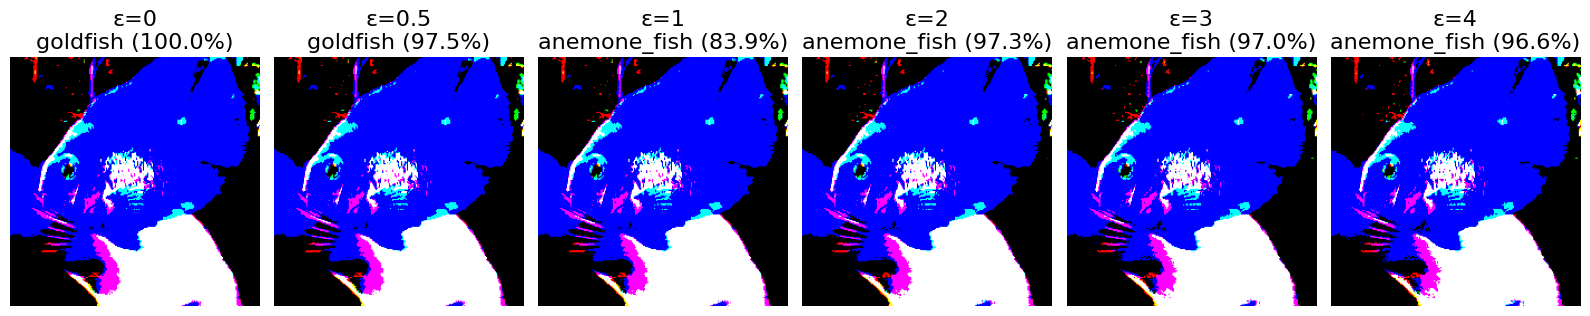

In [ ]:

descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.3f}")
                for eps in epsilons]

#VGG19
# Calcul de la perturbation 
perturbation = create_adversarial_pattern(image_VGG, VGG_model)


fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4))

for col, eps in enumerate(epsilons):
        adv_img = image_VGG + eps * perturbation
        to_show = adv_img[0] 
        
        

        label, conf = get_prediction(VGG_model, adv_img)

        ax = axes[col]
        ax.imshow(to_show)
        ax.set_title(
            f"ε={eps}\n{label} ({conf*100:.1f}%)",
            fontsize=16
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.825935..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.325935..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.714615..152.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.714615..153.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.714615..154.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.714615..155.061].


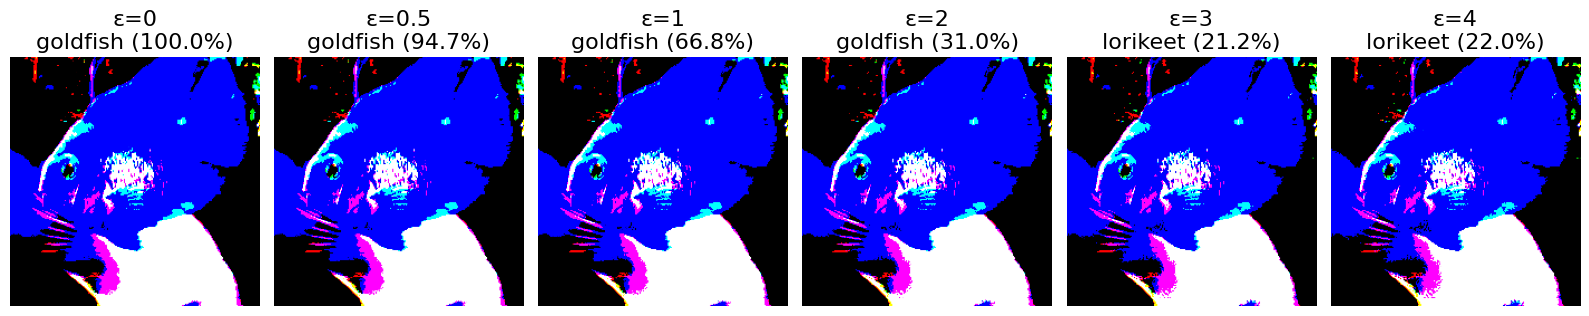

In [ ]:

#ResNet50

perturbation = create_adversarial_pattern(image_ResNet, ResNet_model)


fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4))

for col, eps in enumerate(epsilons):
        adv_img = image_ResNet + eps * perturbation
        to_show = adv_img[0] 
        
        label, conf = get_prediction(ResNet_model, adv_img)

        ax = axes[col]
        ax.imshow(to_show)
        ax.set_title(
            f"ε={eps}\n{label} ({conf*100:.1f}%)",
            fontsize=16
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.01..1.01].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.05..1.05].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1..1.1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3..1.3].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4..1.4].


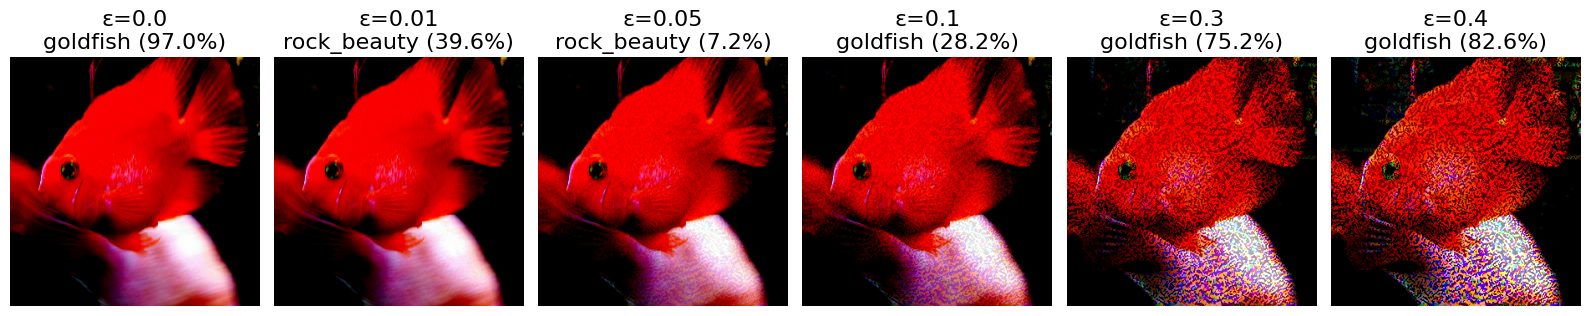

In [ ]:
#InceptionV3

perturbation = create_adversarial_pattern(image_Inception, Inception_model)


fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4))

for col, eps in enumerate(epsilons):
        adv_img = image_Inception + eps/10 * perturbation
        to_show = adv_img[0]
        
        

        label, conf = get_prediction(Inception_model, adv_img)

        ax = axes[col]
        ax.imshow(to_show)
        ax.set_title(
            f"ε={eps/10}\n{label} ({conf*100:.1f}%)",
            fontsize=16
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

#### B: Test pour tout le jeu de données

In [ ]:

from tensorflow.keras.applications import vgg19, resnet50, inception_v3

# =============================
# PARAMÈTRES
# =============================
DATASET_DIR = "./ImageNet-Mini/images"
OUTPUT_DIR = "./FGSM_images"
EPSILONS = [0.5, 1, 3, 5, 7]

models_info = {
    "InceptionV3": {
        "model": Inception_model,
        "size": (299, 299),
        "preprocess": inception_v3.preprocess_input
    },
    "VGG19": {
        "model": VGG_model,
        "size": (224, 224),
        "preprocess": vgg19.preprocess_input
    },
    "ResNet50": {
        "model": ResNet_model,
        "size": (224, 224),
        "preprocess": resnet50.preprocess_input
    }
}



# =============================
# UTILITAIRES
# =============================

def save_adv_image(adv_x, save_path):
    """
    Sauvegarde l'image adversariale au format .npy
    (tensor prétraité directement utilisable par un modèle)
    """
    img = adv_x[0].numpy()   # (H, W, 3) ou (224,224,3)

    # force extension .npy
    if not save_path.endswith(".npy"):
        save_path = save_path.replace(".jpeg", ".npy")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, img)

# =============================
# PIPELINE PRINCIPAL
# =============================
for model_name, info in models_info.items():
    print(f"\n🚀 Processing model: {model_name}")
    model = info["model"]
    size = info["size"]
    preprocess = info["preprocess"]

    for root, _, files in os.walk(DATASET_DIR):
        for fname in files:
            if not fname.lower().endswith(".jpeg"):
                continue

            img_path = os.path.join(root, fname)

            # chemin relatif pour conserver les classes
            rel_path = os.path.relpath(img_path, DATASET_DIR)
            rel_dir = os.path.dirname(rel_path)

            # Chargement image
            img = load_and_preprocess(img_path, size, preprocess)

            # Label top-1 (attaque non ciblée)
            preds = model.predict(img, verbose=0)
            class_idx = tf.argmax(preds[0])
            label = tf.one_hot(class_idx, preds.shape[-1])
            label = tf.reshape(label, (1, preds.shape[-1]))

            # Calcul perturbation UNE FOIS
            perturbation = create_adversarial_pattern(img, label, model)

            for eps in EPSILONS:
                #cas InceptionV3
                if model == Inception_model:
                    eps = eps/10

                out_dir = os.path.join(
                    OUTPUT_DIR, model_name, str(eps), rel_dir
                )
                os.makedirs(out_dir, exist_ok=True)

        
                adv_img = img + eps * perturbation
                #adv_img = tf.clip_by_value(adv_img, -1, 1)

                save_path = os.path.join(out_dir, fname)
                save_adv_image(adv_img, save_path)

    print(f"✅ Finished {model_name}")



🚀 Processing model: InceptionV3
✅ Finished InceptionV3

🚀 Processing model: VGG19
✅ Finished VGG19

🚀 Processing model: ResNet50
✅ Finished ResNet50


In [12]:
def write_results_to_file(filepath, model_name, eps, results):
    with open(filepath, "a", encoding="utf-8") as f:
        f.write(f"\n{'='*60}\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"Epsilon: {eps}\n")
        f.write(f"{'='*60}\n")

        f.write(f"Global Top-1 Accuracy: {results['global_top1']:.2f}%\n")
        f.write(f"Global Top-5 Accuracy: {results['global_top5']:.2f}%\n\n")

        f.write("Most predicted classes (Top-5):\n")
        for cls, count in results["most_predicted_classes"]:
            f.write(f"  - {cls}: {count}\n")

        f.write("\nBest classes (Top-1 accuracy):\n")
        for item in results["best_classes_top1"]:
            f.write(
                f"  - {item['class']}: "
                f"{item['top1_acc']*100:.2f}% "
                f"({item['samples']} samples)\n"
            )

        f.write("\nWorst classes (Top-1 accuracy):\n")
        for item in results["worst_classes_top1"]:
            f.write(
                f"  - {item['class']}: "
                f"{item['top1_acc']*100:.2f}% "
                f"({item['samples']} samples)\n"
            )

        f.write("\n")

    


In [ ]:
EPSILONS = [0.5, 1, 3, 5, 7]

models = {
    "InceptionV3": Inception_model,
    "ResNet50": ResNet_model,
    "VGG19": VGG_model,
}

BASE_DIR = "./FGSM_images"
RESULTS_DIR = "./results_FGSM"
os.makedirs(RESULTS_DIR, exist_ok=True)

for model_name, model in models.items():
    print(f"\n🚀 Evaluating {model_name}")

    result_file = os.path.join(RESULTS_DIR, f"{model_name}_results.txt")

    # Réinitialise le fichier
    with open(result_file, "w", encoding="utf-8") as f:
        f.write(f"Evaluation results for {model_name}\n")

    for eps in EPSILONS:
        if model_name == "InceptionV3":
            eps = eps/10
        print(f"  ε = {eps}")
        eps_dir = os.path.join(BASE_DIR, model_name, str(eps))

        res = evaluate_model(
            model=model,
            model_name=f"{model_name}",
            root_dir=eps_dir
        )

        write_results_to_file(
            filepath=result_file,
            model_name=model_name,
            eps=eps,
            results=res
        )



🚀 Evaluating InceptionV3
  ε = 0.05


InceptionV3: 100%|██████████| 1000/1000 [14:30<00:00,  1.15it/s]


  ε = 0.1


InceptionV3: 100%|██████████| 1000/1000 [14:31<00:00,  1.15it/s]


  ε = 0.3


InceptionV3: 100%|██████████| 1000/1000 [13:19<00:00,  1.25it/s]


  ε = 0.5


InceptionV3: 100%|██████████| 1000/1000 [13:44<00:00,  1.21it/s]


  ε = 0.7


InceptionV3: 100%|██████████| 1000/1000 [12:04<00:00,  1.38it/s]



🚀 Evaluating VGG19
  ε = 0.5


VGG19: 100%|██████████| 1000/1000 [4:18:21<00:00, 15.50s/it]     


  ε = 1


VGG19: 100%|██████████| 1000/1000 [30:07<00:00,  1.81s/it]


  ε = 3


VGG19: 100%|██████████| 1000/1000 [1:13:23<00:00,  4.40s/it]   


  ε = 5


VGG19: 100%|██████████| 1000/1000 [30:21<00:00,  1.82s/it]


  ε = 7


VGG19: 100%|██████████| 1000/1000 [29:27<00:00,  1.77s/it]


In [47]:
def extract_float_from_line(line):
    for token in line.replace("%", "").replace(",", ".").split():
        try:
            return float(token)
        except ValueError:
            continue
    return None

def parse_results_file(path):
    epsilons = []
    top1 = []
    top5 = []

    current_eps = None
    current_top1 = None

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            if line.startswith("Epsilon:"):
                current_eps = extract_float_from_line(line)

            elif line.startswith("Global Top-1 Accuracy:"):
                current_top1 = extract_float_from_line(line)

            elif line.startswith("Global Top-5 Accuracy:"):
                current_top5 = extract_float_from_line(line)

                # 🔴 ON VALIDE LE BLOC ICI
                epsilons.append(current_eps)
                top1.append(current_top1)
                top5.append(current_top5)

    return epsilons, top1, top5


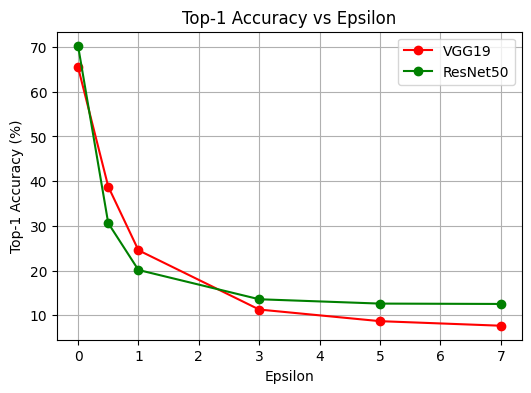

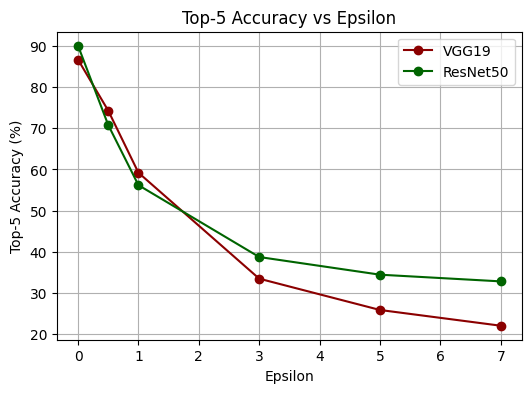

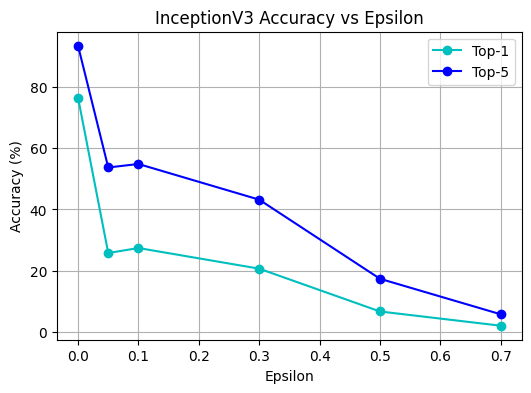

In [55]:

# =========================
# Chargement des résultats
# =========================
RESULTS_DIR = "results_FGSM"
MODELS = ["VGG19", "ResNet50", "InceptionV3"]

results = {}

for model in MODELS:
    eps, t1, t5 = parse_results_file(
        f"{RESULTS_DIR}/{model}_results.txt"
    )

    # Ajout du point epsilon = 0

    TOP1_EPS0 = {
    "VGG19": 65.51,
    "ResNet50": 70.30,
    "InceptionV3": 76.42
    }

    TOP5_EPS0 = {
    "VGG19": 86.72,
    "ResNet50": 90.11,
    "InceptionV3": 93.32
    }

    results[model] = {
        "eps": [0.0] + eps,
        "top1": [TOP1_EPS0[model]] + t1,
        "top5": [TOP5_EPS0[model]] + t5
    }

# =========================
# GRAPHE 1 — Top-1 (VGG19 & ResNet50)
# =========================
plt.figure(figsize=(6, 4))
plt.plot(results["VGG19"]["eps"], results["VGG19"]["top1"],
         marker="o", label="VGG19", color='r')
plt.plot(results["ResNet50"]["eps"], results["ResNet50"]["top1"],
         marker="o", label="ResNet50", color='g')

plt.xlabel("Epsilon")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Top-1 Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# GRAPHE 2 — Top-5 (VGG19 & ResNet50)
# =========================
plt.figure(figsize=(6, 4))
plt.plot(results["VGG19"]["eps"], results["VGG19"]["top5"],
         marker="o", label="VGG19", color='darkred')
plt.plot(results["ResNet50"]["eps"], results["ResNet50"]["top5"],
         marker="o", label="ResNet50", color='darkgreen')

plt.xlabel("Epsilon")
plt.ylabel("Top-5 Accuracy (%)")
plt.title("Top-5 Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# GRAPHE 3 — InceptionV3 (Top-1 & Top-5)
# =========================
plt.figure(figsize=(6, 4))
plt.plot(results["InceptionV3"]["eps"], results["InceptionV3"]["top1"],
         marker="o", label="Top-1", color='c')
plt.plot(results["InceptionV3"]["eps"], results["InceptionV3"]["top5"],
         marker="o", label="Top-5", color='b')

plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.title("InceptionV3 Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()


### 3: Attaque FGSM ciblée
Dans cette partie, nous n'allons travailler que sur une image 

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

#Donne la classe cible
def get_target_label(target_index, image_probs):
    target_label = tf.one_hot(target_index, image_probs.shape[-1])
    target_label = tf.reshape(target_label, (1, image_probs.shape[-1]))
    return target_label


def create_targeted_adversarial_pattern(input_image, input_label, pretrained_model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return -signed_grad # ⬅️ signe inverse


Nous allons donner aux modèles l'image de poisson rouge et essayer de leur faire renvoyer la classe "banana" (banane).

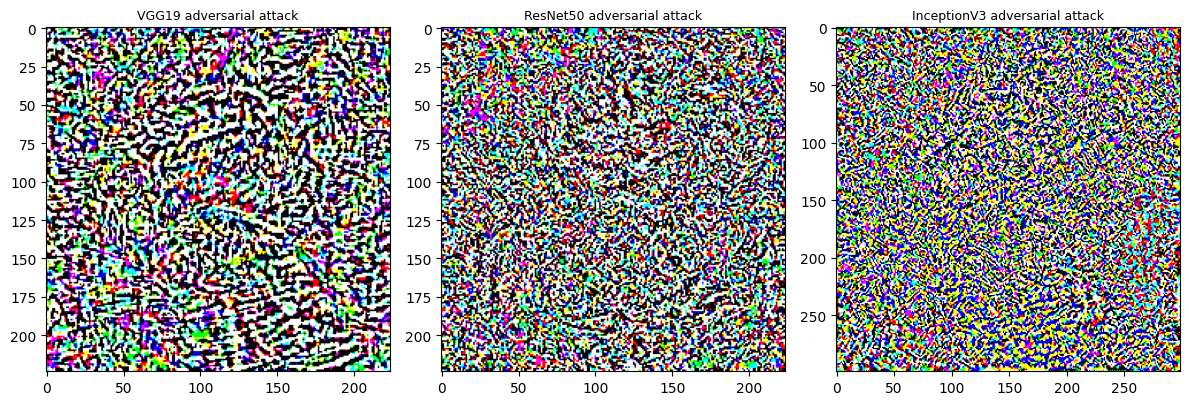

In [ ]:

target_index = 954 #banana

probs = {VGG_model:["VGG19",VGG_image_probs],ResNet_model:["ResNet50",ResNet_image_probs],Inception_model:["InceptionV3",Inception_image_probs]}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))



for ax, (model, prob) in zip(axes, probs.items()):
    #label = get_target_label(probs,target_index)
    label = tf.one_hot(target_index, prob[1].shape[-1])
    label = tf.reshape(label, (1, prob[1].shape[-1]))

    if model == Inception_model:
        perturbations = create_targeted_adversarial_pattern(image_Inception, label, model)
    elif model == ResNet_model:
        perturbations = create_targeted_adversarial_pattern(image_ResNet, label, model)
    else:
        perturbations = create_targeted_adversarial_pattern(image_VGG, label, model)

    ax.imshow(perturbations[0] * 0.5 + 0.5)  # [-1,1] → [0,1]
    ax.set_title(f"{prob[0]} adversarial attack", fontsize=9)
    ax.axis("on")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.325935..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.825935..152.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.49626..153.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.49626..154.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.49626..156.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-124.49626..157.061].


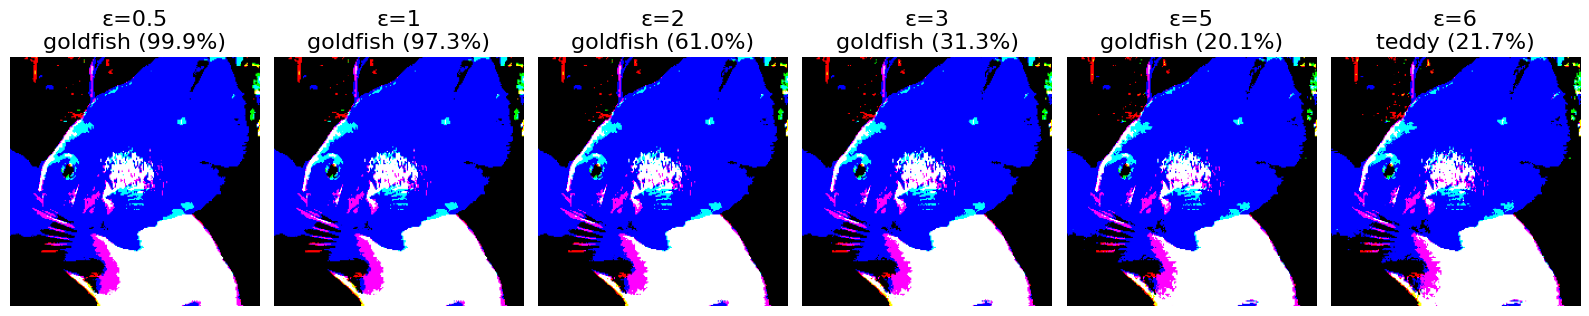

In [ ]:
epsilons = [ 0.5, 1, 2, 3, 5, 6 ]
#VGG19
# Calcul de la perturbation UNE SEULE FOIS
label = get_target_label(target_index, VGG_image_probs)
perturbation = create_targeted_adversarial_pattern(image_VGG, label, VGG_model)


fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4))

for col, eps in enumerate(epsilons):
        adv_img = image_VGG + eps * perturbation
        
        to_show = adv_img[0]

        label, conf = get_prediction(VGG_model, adv_img)

        ax = axes[col]
        ax.imshow(to_show)
        ax.set_title(
            f"ε={eps}\n{label} ({conf*100:.1f}%)",
            fontsize=16
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.325935..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.714615..152.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.714615..153.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.714615..154.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-124.714615..156.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-125.714615..157.061].


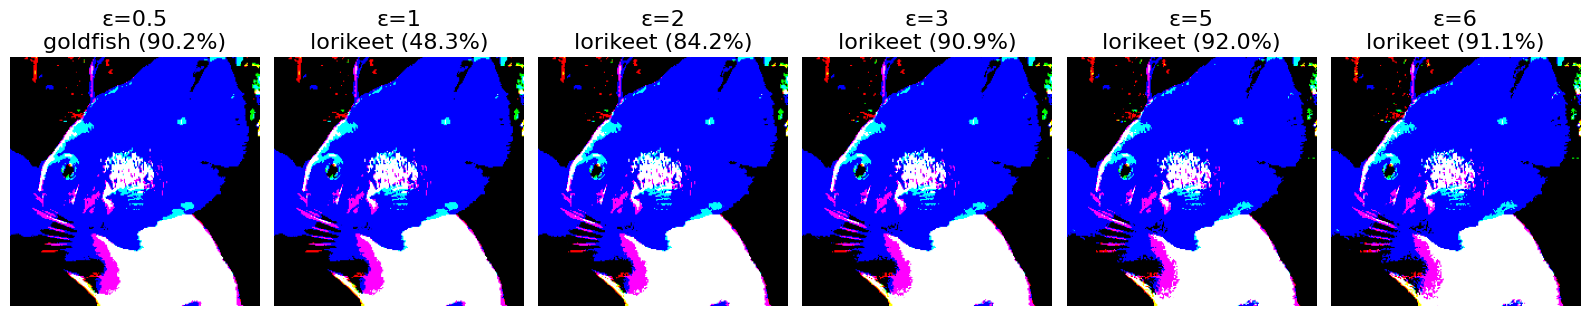

In [57]:
label = get_target_label(target_index, ResNet_image_probs)
perturbation = create_targeted_adversarial_pattern(image_ResNet, label, ResNet_model)

#ResNet50
fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4))

for col, eps in enumerate(epsilons):
        adv_img = image_ResNet + eps * perturbation
        #to_show = adv_img[0] * 0.5 + 0.5
        #to_show = tf.clip_by_value(to_show, 0, 1)
        to_show = adv_img[0]

        label, conf = get_prediction(ResNet_model, adv_img)

        ax = axes[col]
        ax.imshow(to_show)
        ax.set_title(
            f"ε={eps}\n{label} ({conf*100:.1f}%)",
            fontsize=16
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.01..1.01].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.05..1.05].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1..1.1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3..1.3].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4..1.4].


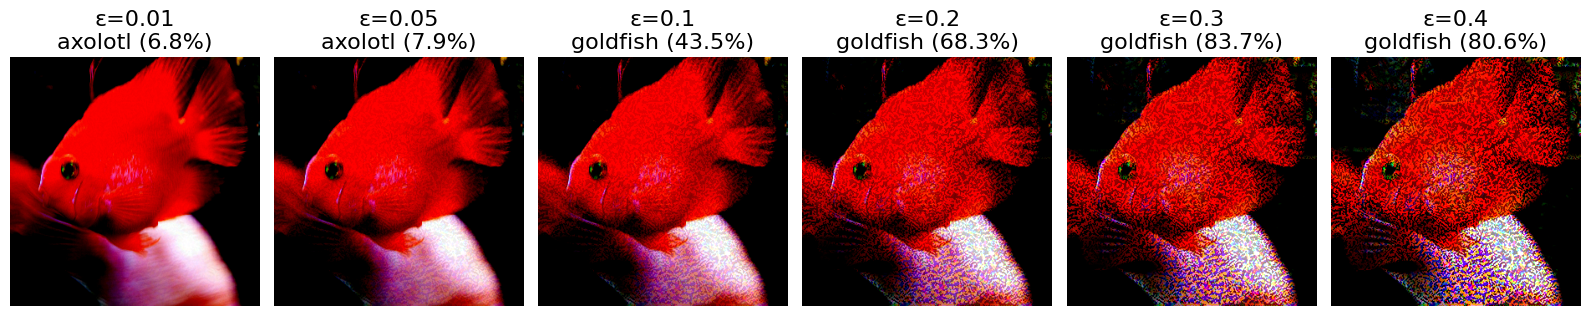

In [47]:
epsilons = [ 0.1, 0.5, 1, 2, 3, 4]
label = get_target_label(target_index, Inception_image_probs)
perturbation = create_targeted_adversarial_pattern(image_Inception, label, Inception_model)


fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4))

for col, eps in enumerate(epsilons):
        adv_img = image_Inception + eps/10 * perturbation
        #to_show = adv_img[0] * 0.5 + 0.5
        #to_show = tf.clip_by_value(to_show, 0, 1)
        to_show = adv_img[0]
        

        label, conf = get_prediction(Inception_model, adv_img)

        ax = axes[col]
        ax.imshow(to_show)
        ax.set_title(
            f"ε={eps/10}\n{label} ({conf*100:.1f}%)",
            fontsize=16
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

### 4: Attaques FGSM itératives

#### A: Attaque FGSM itérative non ciblée 

In [48]:
def create_iterative_fgsm(
    model,
    image,
    label,
    epsilon=0.15,
    alpha=0.01,
    num_iters=10,
    clip_min=None,
    clip_max=None
):
    """
    I-FGSM (Iterative FGSM) non ciblée

    image : image prétraitée (1,H,W,3)
    label : one-hot (1,1000)
    """

    adv = tf.identity(image)
    loss_object = tf.keras.losses.CategoricalCrossentropy()

    for _ in range(num_iters):
        with tf.GradientTape() as tape:
            tape.watch(adv)
            preds = model(adv)
            loss = loss_object(label, preds)

        # Gradient
        grad = tape.gradient(loss, adv)
        signed_grad = tf.sign(grad)

        # Pas itératif
        adv = adv + alpha * signed_grad

        # Projection dans la boule epsilon
        adv = tf.clip_by_value(
            adv,
            image - epsilon,
            image + epsilon
        )

        # Clip final selon le modèle
        if clip_min is not None and clip_max is not None:
            adv = tf.clip_by_value(adv, clip_min, clip_max)

    return adv


In [18]:
def get_prediction(model, img):
    preds = model.predict(img, verbose=0)
    decoded = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=1)[0][0]
    class_name = decoded[1]
    confidence = decoded[2]
    return class_name, confidence

In [ ]:
goldfish_index = 2 #goldfissh
epsilons = [0, 0.5, 1, 2, 3, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.825935..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.325935..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.714615..152.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.5146..153.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.5146..153.06113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.5146..153.06113].


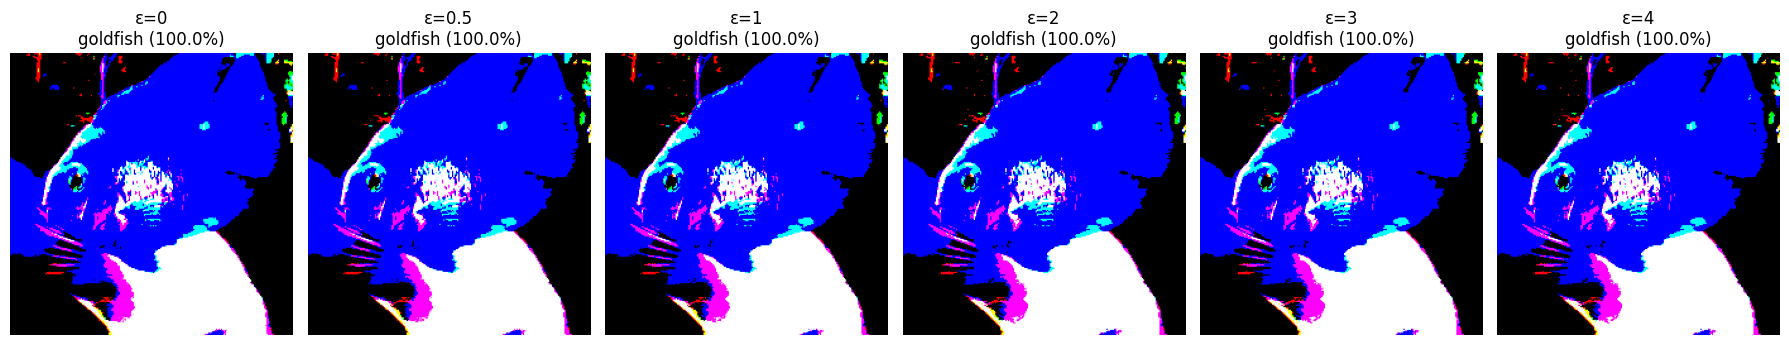

In [ ]:
#VGG19

descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.2f}")
                for eps in epsilons]

# Label cible
label = get_target_label(goldfish_index, VGG_image_probs)

fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 4))

for col, eps in enumerate(epsilons):

    if eps == 0:
        adv_img = image_VGG
    else:
        adv_img = create_iterative_fgsm(
            model=VGG_model,
            image=image_VGG,
            label=label,
            epsilon=eps,
            alpha=0.1,     # pas raisonnable
            num_iters=20
        )

    # ⚠️ image déjà prétraitée VGG → affichage brut
    to_show = adv_img[0]
    #to_show = tf.clip_by_value(to_show, 0, 255) / 255.0

    pred_label, conf = get_prediction(VGG_model, adv_img)

    ax = axes[col]
    ax.imshow(to_show)
    ax.set_title(
        f"ε={eps}\n{pred_label} ({conf*100:.1f}%)",
        fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.825935..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.22594..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.825935..151.86105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.02592..152.06107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.02592..152.06107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.02592..152.06107].


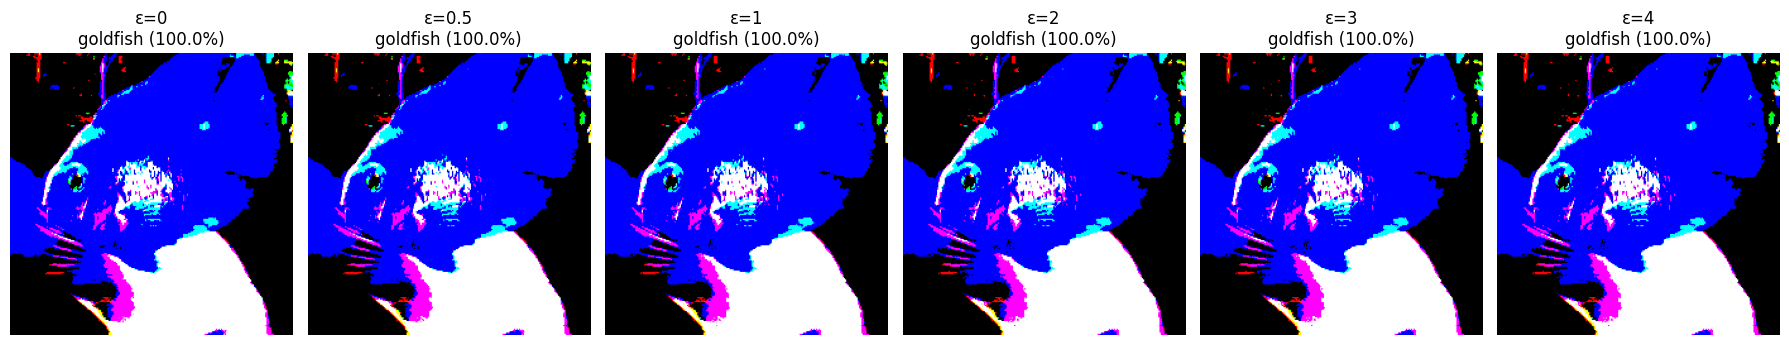

In [ ]:
#ResNet50

descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.2f}")
                for eps in epsilons]

# Label cible
label = get_target_label(goldfish_index, ResNet_image_probs)

fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 4))

for col, eps in enumerate(epsilons):

    if eps == 0:
        adv_img = image_ResNet
    else:
        adv_img = create_iterative_fgsm(
            model=ResNet_model,
            image=image_ResNet,
            label=label,
            epsilon=eps,
            alpha=1/10,     # pas raisonnable
            num_iters=20
        )

    # ⚠️ image déjà prétraitée VGG → affichage brut
    to_show = adv_img[0]
    #to_show = tf.clip_by_value(to_show, 0, 255) / 255.0

    pred_label, conf = get_prediction(ResNet_model, adv_img)

    ax = axes[col]
    ax.imshow(to_show)
    ax.set_title(
        f"ε={eps}\n{pred_label} ({conf*100:.1f}%)",
        fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.02..1.02].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.05..1.05].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1..1.1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4..1.4].


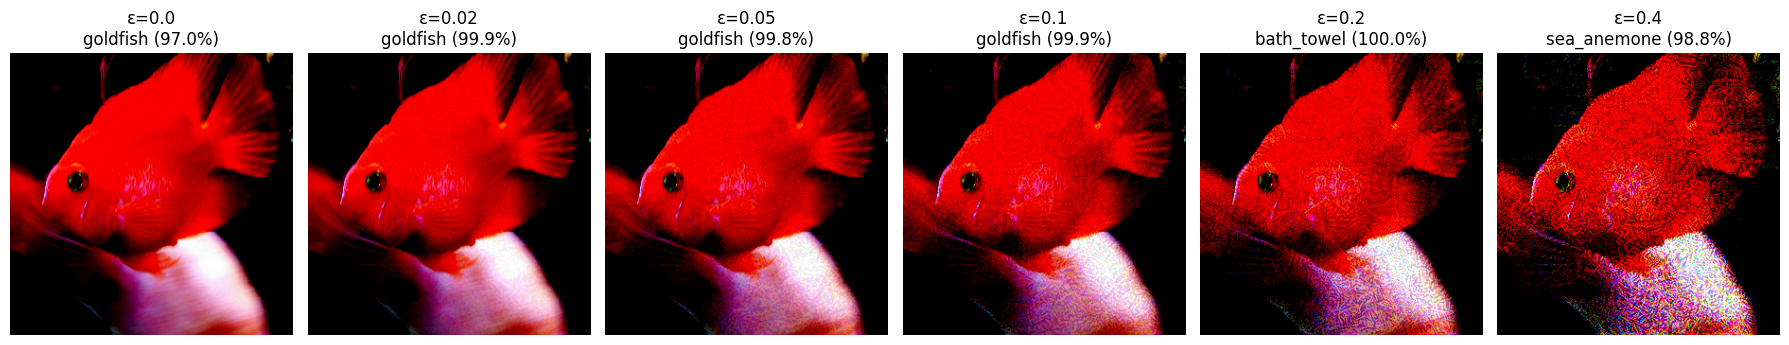

In [ ]:
#InceptionV3


descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.2f}")
                for eps in epsilons]

# Label cible
label = get_target_label(goldfish_index, Inception_image_probs)

fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 4))

for col, eps in enumerate(epsilons):
    eps = eps/10
    if eps == 0:
        adv_img = image_Inception
    else:
        adv_img = create_iterative_fgsm(
            model=Inception_model,
            image=image_Inception,
            label=label,
            epsilon=eps,
            alpha= 1/10,     # pas raisonnable
            num_iters=20
        )

    # ⚠️ image déjà prétraitée VGG → affichage brut
    to_show = adv_img[0]
    

    pred_label, conf = get_prediction(Inception_model, adv_img)

    ax = axes[col]
    ax.imshow(to_show)
    ax.set_title(
        f"ε={eps}\n{pred_label} ({conf*100:.1f}%)",
        fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

#### B: Attaque FGSM itérative ciblée

In [4]:
def create_targeted_iterative_fgsm(
    model,
    image,
    target_label,
    epsilon=0.15,
    alpha=0.01,
    num_iters=10,
    clip_min=None,
    clip_max=None
):
    """
    I-FGSM (Iterative FGSM) non ciblée

    image : image prétraitée (1,H,W,3)
    label : one-hot (1,1000)
    """

    adv = tf.identity(image)
    loss_object = tf.keras.losses.CategoricalCrossentropy()

    for _ in range(num_iters):
        with tf.GradientTape() as tape:
            tape.watch(adv)
            preds = model(adv)
            loss = loss_object(target_label, preds)

        # Gradient
        grad = tape.gradient(loss, adv)
        signed_grad = tf.sign(grad)

        # Pas itératif
        adv = adv - alpha * signed_grad

        # Projection dans la boule epsilon
        adv = tf.clip_by_value(
            adv,
            image - epsilon,
            image + epsilon
        )

        # Clip final selon le modèle
        if clip_min is not None and clip_max is not None:
            adv = tf.clip_by_value(adv, clip_min, clip_max)

    return adv


In [5]:
target_index = 954 #banana
epsilons = [0, 0.2, 0.5, 1, 2, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


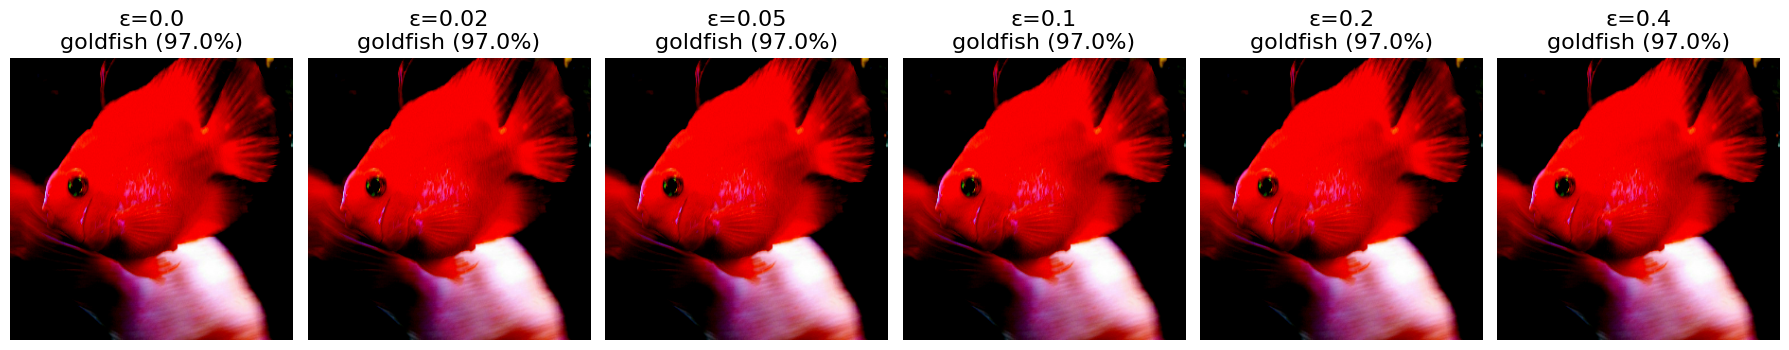

In [20]:

descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.2f}")
                for eps in epsilons]

# Label cible
label = get_target_label(target_index, Inception_image_probs)

fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 4))

for col, eps in enumerate(epsilons):
    eps = eps/10
    if eps == 0:
        adv_img = image_Inception
    else:
        adv_img = create_targeted_iterative_fgsm(
            model=Inception_model,
            image=image_Inception,
            target_label=label,
            epsilon=eps,
            alpha= 1/10,     # pas raisonnable
            num_iters=0
        )

    # ⚠️ image déjà prétraitée VGG → affichage brut
    to_show = adv_img[0]
    #to_show = tf.clip_by_value(to_show, 0, 255) / 255.0

    pred_label, conf = get_prediction(Inception_model, adv_img)

    ax = axes[col]
    ax.imshow(to_show)
    ax.set_title(
        f"ε={eps}\n{pred_label} ({conf*100:.1f}%)",
        fontsize=16
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.825935..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.62594..151.261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.02593..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.02593..151.92975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.02593..151.92981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.02593..151.92981].


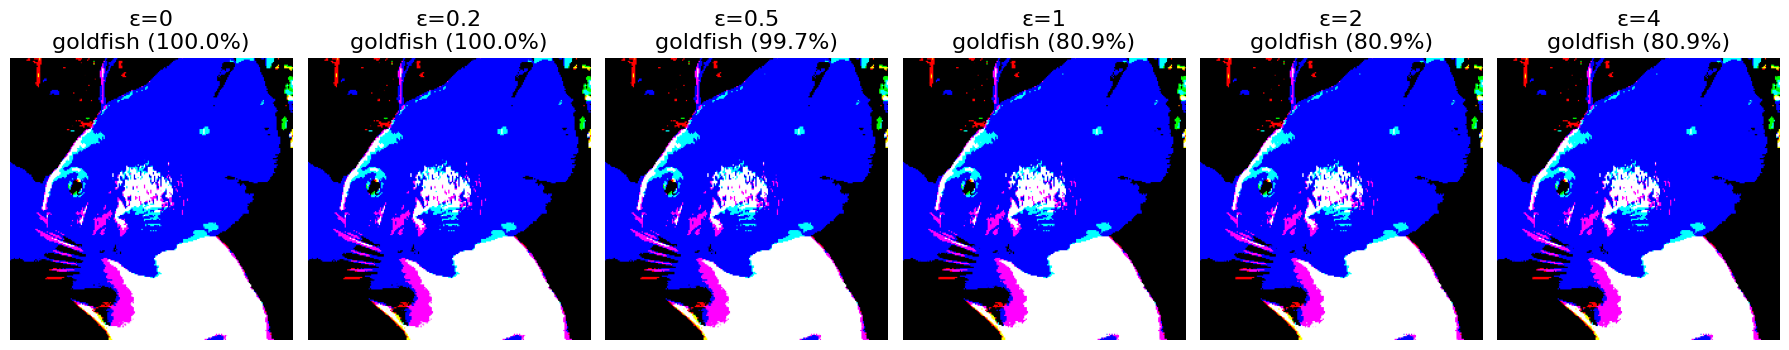

In [ ]:
#VGG19

descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.2f}")
                for eps in epsilons]

# Label cible
label = get_target_label(target_index, VGG_image_probs)

fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 4))

for col, eps in enumerate(epsilons):
    #eps = eps/10
    if eps == 0:
        adv_img = image_VGG
    else:
        adv_img = create_targeted_iterative_fgsm(
            model=VGG_model,
            image=image_VGG,
            target_label=label,
            epsilon=eps,
            alpha= 1/10,     # pas raisonnable
            num_iters=10
        )

    
    to_show = adv_img[0]
    

    pred_label, conf = get_prediction(VGG_model, adv_img)

    ax = axes[col]
    ax.imshow(to_show)
    ax.set_title(
        f"ε={eps}\n{pred_label} ({conf*100:.1f}%)",
        fontsize=16
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.825935..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.02593..151.261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.22594..151.561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.62592..152.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.62592..152.06107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.62592..152.06107].


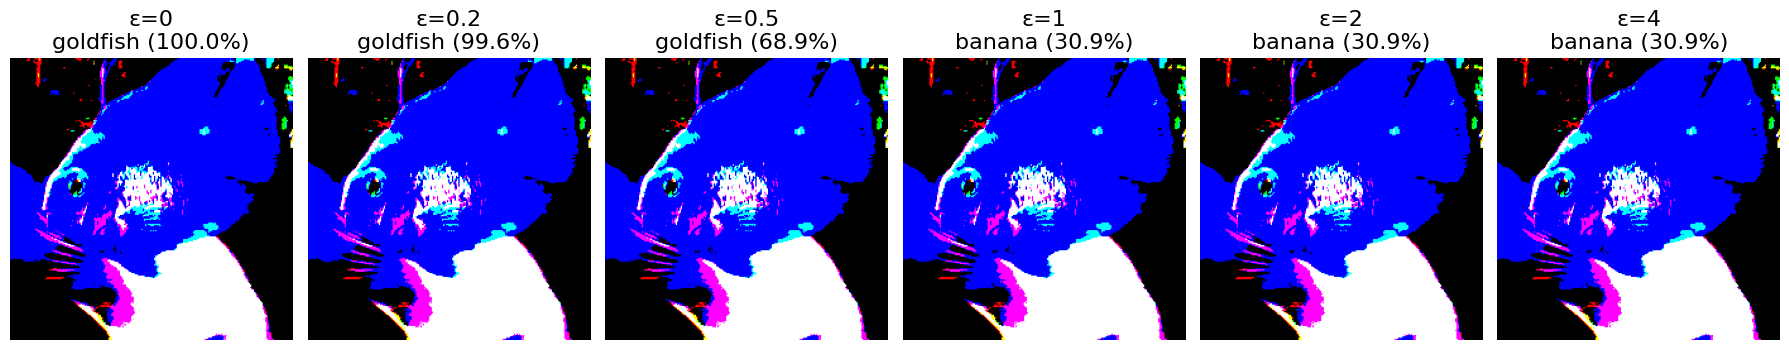

In [22]:
#ResNet50

descriptions = [('Input' if eps == 0 else f"Epsilon = {eps:.2f}")
                for eps in epsilons]

# Label cible
label = get_target_label(target_index, ResNet_image_probs)

fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 4))

for col, eps in enumerate(epsilons):
    #eps = eps/10
    if eps == 0:
        adv_img = image_ResNet
    else:
        adv_img = create_targeted_iterative_fgsm(
            model=ResNet_model,
            image=image_ResNet,
            target_label=label,
            epsilon=eps,
            alpha= 1/10,     # pas raisonnable
            num_iters=10
        )

    
    to_show = adv_img[0]
    

    pred_label, conf = get_prediction(ResNet_model, adv_img)

    ax = axes[col]
    ax.imshow(to_show)
    ax.set_title(
        f"ε={eps}\n{pred_label} ({conf*100:.1f}%)",
        fontsize=16
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

####

#### C: Targeted iterative FGSM on several classes

In [ ]:
import random


# =============================
# Sélection de 100 classes aléatoires sauf banana
# =============================
DATASET_DIR = "./ImageNet-Mini/images"
# Charger mapping wnid → index ImageNet
with open("./ImageNet-Mini/imagenet_class_index.json", "r") as f:
    imagenet_index = json.load(f)

wnid_to_imagenet = {v[0]: int(k) for k, v in imagenet_index.items()}

# Lister toutes les classes (dossiers)
all_classes = [
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
]

# Retirer la classe banana (index 954)
filtered_classes = [
    wnid for wnid in all_classes
    if wnid_to_imagenet.get(wnid) != target_index
]

# Tirage aléatoire de 100 classes
selected_classes = random.sample(filtered_classes, 10)

print("✅ Classes sélectionnées :", selected_classes[:5], "...")


✅ Classes sélectionnées : ['n02089867', 'n02437616', 'n04326547', 'n01739381', 'n04209133'] ...


Il s'agit d'une étape de génération d'image qui peut prendre beaucoup de temps

In [ ]:

# =============================
# PARAMÈTRES
# =============================

OUTPUT_DIR = "./I-FGSM_images_banana"
EPSILONS = [0, 0.5, 1, 3, 5, 7]
target_index = 954 #banana

models_info = {
    "InceptionV3": {
        "model": Inception_model,
        "size": (299, 299),
        "preprocess": inception_v3.preprocess_input
    },
    "VGG19": {
        "model": VGG_model,
        "size": (224, 224),
        "preprocess": vgg19.preprocess_input
    },
    "ResNet50": {
        "model": ResNet_model,
        "size": (224, 224),
        "preprocess": resnet50.preprocess_input
    }
}

loss_object = tf.keras.losses.CategoricalCrossentropy()

# =============================
# FGSM
# =============================
def create_targeted_iterative_fgsm(
    model,
    image,
    target_label,
    epsilon,
    alpha,
    num_iters=10,
    clip_min=None,
    clip_max=None
):
    """
    I-FGSM (Iterative FGSM) non ciblée

    image : image prétraitée (1,H,W,3)
    label : one-hot (1,1000)
    """

    adv = tf.identity(image)
    loss_object = tf.keras.losses.CategoricalCrossentropy()

    for _ in range(num_iters):
        with tf.GradientTape() as tape:
            tape.watch(adv)
            preds = model(adv)
            loss = loss_object(target_label, preds)

        # Gradient
        grad = tape.gradient(loss, adv)
        signed_grad = tf.sign(grad)

        # Pas itératif
        adv = adv - alpha * signed_grad

        # Projection dans la boule epsilon
        adv = tf.clip_by_value(
            adv,
            image - epsilon,
            image + epsilon
        )

        # Clip final selon le modèle
        if clip_min is not None and clip_max is not None:
            adv = tf.clip_by_value(adv, clip_min, clip_max)

    return adv

# =============================
# UTILITAIRES
# =============================
def get_target_label(target_index, image_probs):
    target_label = tf.one_hot(target_index, image_probs.shape[-1])
    target_label = tf.reshape(target_label, (1, image_probs.shape[-1]))
    return target_label

def load_and_preprocess(img_path, size, preprocess): #ne marche pas pour evaluate model()
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.cast(img, tf.float64)
    img = tf.image.resize(img, size)
    img = preprocess(img)
    return img[None, ...]

def save_adv_image(adv_x, save_path):
    """
    Sauvegarde l'image adversariale au format .npy
    (tensor prétraité directement utilisable par un modèle)
    """
    img = adv_x[0].numpy()   # (H, W, 3) ou (224,224,3)

    # force extension .npy
    if not save_path.endswith(".npy"):
        save_path = save_path.replace(".jpeg", ".npy")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, img)

# =============================
# PIPELINE PRINCIPAL
# =============================
# Label cible
label = get_target_label(target_index, VGG_image_probs)

for model_name, info in models_info.items():
    print(f"\n🚀 Processing model: {model_name}")
    model = info["model"]
    size = info["size"]
    preprocess = info["preprocess"]

    for wnid in selected_classes:
        class_dir = os.path.join(DATASET_DIR, wnid)

        for fname in os.listdir(class_dir):
            if not fname.lower().endswith(".jpeg"):
                continue

            img_path = os.path.join(class_dir, fname)

            # Chargement image
            img = load_and_preprocess(img_path, size, preprocess)

            for eps in EPSILONS:
                if model == Inception_model:
                    eps = eps / 10

                out_dir = os.path.join(
                    OUTPUT_DIR, model_name, str(eps), wnid
                )
                os.makedirs(out_dir, exist_ok=True)

                perturbation = create_targeted_iterative_fgsm(
                    model=model,
                    image=img,
                    target_label=label,
                    epsilon=eps,
                    alpha=0.1
                )

                adv_img = img + eps * perturbation

                save_path = os.path.join(out_dir, fname)
                save_adv_image(adv_img, save_path)

    print(f"✅ Finished {model_name}")



🚀 Processing model: InceptionV3
✅ Finished InceptionV3


In [26]:
def write_results_to_file(filepath, model_name, eps, results):
    with open(filepath, "a", encoding="utf-8") as f:
        f.write(f"\n{'='*60}\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"Epsilon: {eps}\n")
        f.write(f"{'='*60}\n")

        f.write(f"Global Top-1 Accuracy: {results['global_top1']:.2f}%\n")
        f.write(f"Global Top-5 Accuracy: {results['global_top5']:.2f}%\n\n")

        f.write("Most predicted classes (Top-5):\n")
        for cls, count in results["most_predicted_classes"]:
            f.write(f"  - {cls}: {count}\n")

        f.write("\nBest classes (Top-1 accuracy):\n")
        for item in results["best_classes_top1"]:
            f.write(
                f"  - {item['class']}: "
                f"{item['top1_acc']*100:.2f}% "
                f"({item['samples']} samples)\n"
            )

        f.write("\nWorst classes (Top-1 accuracy):\n")
        for item in results["worst_classes_top1"]:
            f.write(
                f"  - {item['class']}: "
                f"{item['top1_acc']*100:.2f}% "
                f"({item['samples']} samples)\n"
            )

        f.write("\n")

    


In [42]:
models = {
    "InceptionV3": Inception_model,
    "ResNet50": ResNet_model,
    "VGG19": VGG_model,
}

BASE_DIR = OUTPUT_DIR
RESULTS_DIR = "./results_I-FGSM"
os.makedirs(RESULTS_DIR, exist_ok=True)

for model_name, model in models.items():
    print(f"\n🚀 Evaluating {model_name}")

    result_file = os.path.join(RESULTS_DIR, f"{model_name}_results.txt")

    # Réinitialise le fichier
    with open(result_file, "w", encoding="utf-8") as f:
        f.write(f"Evaluation results for {model_name}\n")

    for eps in EPSILONS:
        if model_name == "InceptionV3":
            eps = eps/10
        print(f"  ε = {eps}")
        eps_dir = os.path.join(BASE_DIR, model_name, str(eps))

        res = evaluate_model(
            model=model,
            model_name=f"{model_name}",
            root_dir=eps_dir
        )

        write_results_to_file(
            filepath=result_file,
            model_name=model_name,
            eps=eps,
            results=res
        )


🚀 Evaluating InceptionV3
  ε = 0.0


InceptionV3: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


  ε = 0.05


InceptionV3: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


  ε = 0.1


InceptionV3: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


  ε = 0.3


InceptionV3: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


  ε = 0.5


InceptionV3: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


  ε = 0.7


InceptionV3: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]



🚀 Evaluating ResNet50
  ε = 0


ResNet50: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


  ε = 0.5


ResNet50: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


  ε = 1


ResNet50: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


  ε = 3


ResNet50: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


  ε = 5


ResNet50: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


  ε = 7


ResNet50: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]



🚀 Evaluating VGG19
  ε = 0


VGG19: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


  ε = 0.5


VGG19: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


  ε = 1


VGG19: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


  ε = 3


VGG19: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


  ε = 5


VGG19: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


  ε = 7


VGG19: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


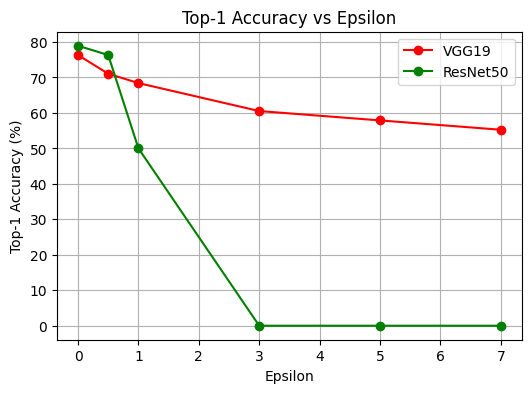

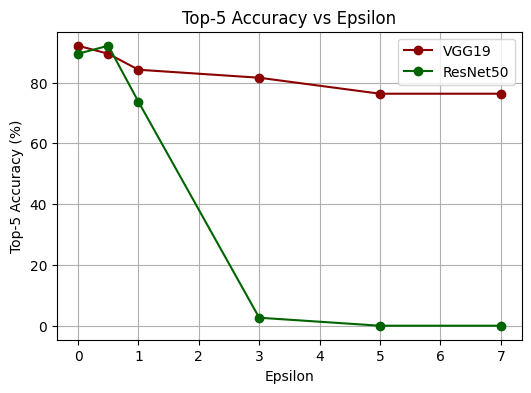

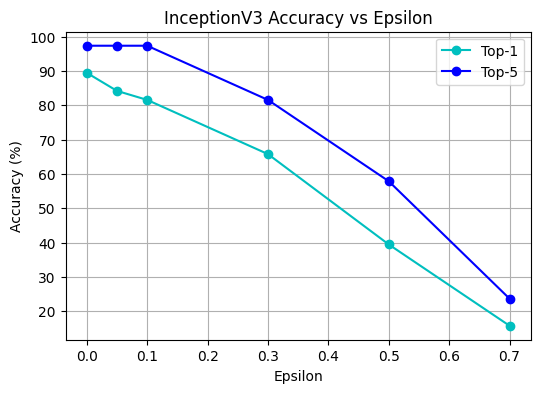

In [56]:
# =========================
# Chargement des résultats
# =========================
RESULTS_DIR = "results_I-FGSM"
MODELS = ["VGG19", "ResNet50", "InceptionV3"]

results = {}

for model in MODELS:
    eps, t1, t5 = parse_results_file(
        f"{RESULTS_DIR}/{model}_results.txt"
    )

    

    results[model] = {
        "eps": eps,
        "top1": t1,
        "top5": t5
    }

# =========================
# GRAPHE 1 — Top-1 (VGG19 & ResNet50)
# =========================
plt.figure(figsize=(6, 4))
plt.plot(results["VGG19"]["eps"], results["VGG19"]["top1"],
         marker="o", label="VGG19", color='r')
plt.plot(results["ResNet50"]["eps"], results["ResNet50"]["top1"],
         marker="o", label="ResNet50", color='g')

plt.xlabel("Epsilon")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Top-1 Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# GRAPHE 2 — Top-5 (VGG19 & ResNet50)
# =========================
plt.figure(figsize=(6, 4))
plt.plot(results["VGG19"]["eps"], results["VGG19"]["top5"],
         marker="o", label="VGG19", color='darkred')
plt.plot(results["ResNet50"]["eps"], results["ResNet50"]["top5"],
         marker="o", label="ResNet50", color='darkgreen')

plt.xlabel("Epsilon")
plt.ylabel("Top-5 Accuracy (%)")
plt.title("Top-5 Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# GRAPHE 3 — InceptionV3 (Top-1 & Top-5)
# =========================
plt.figure(figsize=(6, 4))
plt.plot(results["InceptionV3"]["eps"], results["InceptionV3"]["top1"],
         marker="o", label="Top-1", color='c')
plt.plot(results["InceptionV3"]["eps"], results["InceptionV3"]["top5"],
         marker="o", label="Top-5", color='b')

plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.title("InceptionV3 Accuracy vs Epsilon")
plt.legend()
plt.grid(True)
plt.show()


### Bonus: essai avec un modèle hybride
#### ResNet50 + RBF 

In [ ]:
base = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg"
)

base.trainable = False   


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 66s 1us/step


In [6]:
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0):
        super().__init__()
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name="centers",
            shape=(self.units, input_shape[-1]),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        # ||x - c||^2
        x = tf.expand_dims(inputs, 1)        # (B,1,D)
        c = tf.expand_dims(self.centers, 0)  # (1,U,D)
        return tf.exp(-self.gamma * tf.reduce_sum((x - c)**2, axis=-1))


In [9]:
inputs = tf.keras.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = RBFLayer(units=128, gamma=0.5)(x)
outputs = tf.keras.layers.Dense(1000, activation="softmax")(x)

ResNet_model_RBF = tf.keras.Model(inputs, outputs)


In [ ]:

from tensorflow.keras.preprocessing import image_dataset_from_directory

# =============================
# 1️⃣ Charger les classes ImageNet-Mini
# =============================
with open("./ImageNet-Mini/imagenet_class_index.json", "r") as f:
    imagenet_index = json.load(f)

num_classes = len(imagenet_index)

# =============================
# 2️⃣ Dataset
# =============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    "./ImageNet-Mini/images",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",   # one-hot
    shuffle=True
)

# Preprocess ResNet
preprocess = tf.keras.applications.resnet50.preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess(x), y))

# =============================
# 3️⃣ Modèle CNN + RBF
# =============================

class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=0.5):
        super().__init__()
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            shape=(self.units, input_shape[-1]),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        x = tf.expand_dims(inputs, 1)
        c = tf.expand_dims(self.centers, 0)
        return tf.exp(-self.gamma * tf.reduce_sum((x - c)**2, axis=-1))


base = ResNet50(weights="imagenet", include_top=False, pooling="avg")
base.trainable = False   # 👈 on gèle ResNet

inputs = tf.keras.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = RBFLayer(units=128, gamma=0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

ResNet_model_RBF = tf.keras.Model(inputs, outputs)

# =============================
# 4️⃣ Compile
# =============================
ResNet_model_RBF.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ResNet_model_RBF.summary()

# =============================
# 5️⃣ Entraînement
# =============================
history = model.fit(
    train_ds,
    epochs=10
)

# =============================
# 6️⃣ Sauvegarde
# =============================
ResNet_model_RBF.save("resnet_rbf_imagenetmini.h5")


Found 3923 files belonging to 1000 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rbf_layer_4 (RBFLayer)          │ (None, 128)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,978,856 (91.47 MB)

 Trainable params: 391,144 (1.49 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.0020 - loss: 6.9054
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.0031 - loss: 6.9029
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.0025 - loss: 6.9006
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.0036 - loss: 6.8985
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.0036 - loss: 6.8964
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.0036 - loss: 6.8944
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.0036 - loss: 6.8925
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.0036 - loss: 6.8907
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.0036 - loss: 6.8889
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.0036 - loss: 6.8872


Les performence ne sont vraiement pas bonnes...